In [60]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();
sns.set(font_scale=2);
import numpy as np
from pylab import rcParams
import statsmodels.api as sm
import itertools
import warnings
import holidays
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Data

In [61]:
# Read csv with total net sales daily
df = pd.read_csv('../data/net_sales_total.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Read csv with daily weather
weather_df = pd.read_csv('../data/dark_sky_api.csv')
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df = weather_df.rename(columns={'time':'date'})
weather_df = weather_df.set_index('date')

# Merge both dataframes
df = df.merge(weather_df, on='date')

In [62]:
# df = df[df['total']>50]

In [63]:
df = df.reset_index()
df['day_of_week'] = df['date'].dt.day_name()
df['week_of_year'] = df['date'].dt.weekofyear
df['month_name'] = df['date'].dt.month_name()
df['quarter'] = df['date'].dt.quarter

df = df.set_index('date')

In [64]:
df

,total,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,...,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,ozone,Unnamed: 39,day_of_week,week_of_year,month_name,quarter
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2249.22,Clear throughout the day.,clear-day,1420114920,1420148460,0.40,0.0000,0.0000,NaN,0.00,...,20.90,1420110180,35.46,1420147860,NaN,NaN,Thursday,1,January,1
2015-01-02,1682.68,Mostly cloudy throughout the day.,partly-cloudy-day,1420201320,1420234920,0.43,0.0000,0.0000,NaN,0.00,...,29.76,1420196160,38.64,1420231080,NaN,NaN,Friday,1,January,1
2015-01-03,2550.18,Rain starting in the afternoon.,rain,1420287720,1420321380,0.46,0.0243,0.1062,NaN,1.00,...,29.46,1420283040,41.21,1420336080,NaN,NaN,Saturday,1,January,1
2015-01-04,1964.54,"Light rain until morning, starting again in th...",rain,1420374120,1420407840,0.50,0.0139,0.1195,NaN,1.00,...,39.30,1420347600,54.75,1420415160,NaN,NaN,Sunday,1,January,1
2015-01-05,1029.82,Partly cloudy throughout the day.,partly-cloudy-day,1420460520,1420494300,0.53,0.0000,0.0000,NaN,0.00,...,14.61,1420516800,45.21,1420434000,NaN,NaN,Monday,2,January,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-16,1324.25,Light rain in the morning.,rain,1579177140,1579211760,0.73,0.0039,0.0327,1.579162e+09,0.91,...,24.42,1579233600,43.15,1579186920,330.7,NaN,Thursday,3,January,1
2020-01-17,2364.00,Clear throughout the day.,clear-day,1579263540,1579298220,0.77,0.0007,0.0025,1.579266e+09,0.06,...,8.98,1579265940,22.52,1579237200,343.8,0.19,Friday,3,January,1
2020-01-18,2686.50,Light snow starting in the afternoon.,snow,1579349880,1579384680,0.80,0.0106,0.0448,1.579393e+09,0.77,...,11.89,1579323600,27.36,1579402800,291.7,1.91,Saturday,3,January,1


### Daily EDA

Plotting daily sales for whole dataset

In [5]:
df.tail()

,total,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,...,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,ozone,Unnamed: 39,day_of_week,week_of_year,month_name,quarter
date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1324.25,Light rain in the morning.,rain,1579177140,1579211760,0.73,0.0039,0.0327,1.579162e+09,0.91,...,24.42,1579233600,43.15,1579186920,330.7,NaN,Thursday,3,January,1
2020-01-17,2364.00,Clear throughout the day.,clear-day,1579263540,1579298220,0.77,0.0007,0.0025,1.579266e+09,0.06,...,8.98,1579265940,22.52,1579237200,343.8,0.19,Friday,3,January,1
2020-01-18,2686.50,Light snow starting in the afternoon.,snow,1579349880,1579384680,0.80,0.0106,0.0448,1.579393e+09,0.77,...,11.89,1579323600,27.36,1579402800,291.7,1.91,Saturday,3,January,1
2020-01-19,3768.75,Possible drizzle in the morning.,rain,1579436280,1579471140,0.84,0.0024,0.0152,1.579424e+09,0.50,...,20.28,1579492800,35.03,1579447080,351.8,NaN,Sunday,3,January,1
2020-01-20,2021.50,Clear throughout the day.,clear-day,1579522620,1579557600,0.87,0.0004,0.0022,1.579529e+09,0.05,...,8.78,1579518240,22.90,1579549020,354.0,0.11,Monday,4,January,1


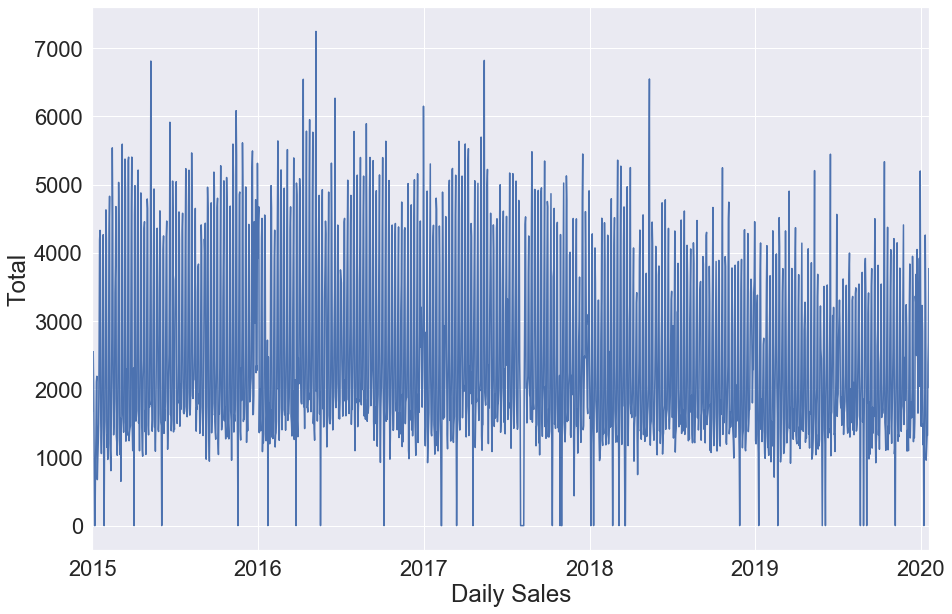

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
ax = df['total'].plot()
ax.set_xlabel('Daily Sales');
ax.set_ylabel('Total');

Plotting daily max temp for whole dataset

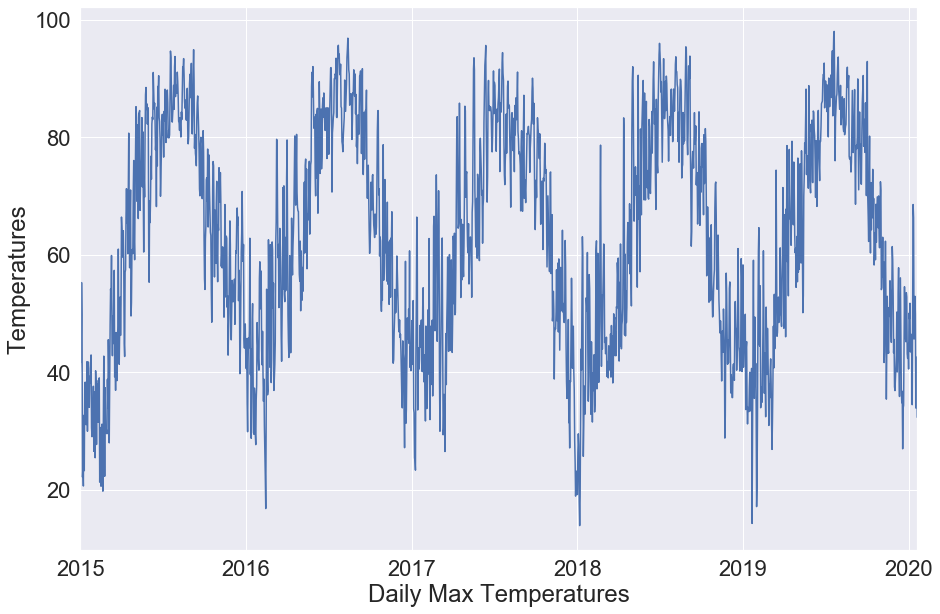

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
df['temperatureMax'].plot()
ax.set_xlabel('Daily Max Temperatures');
ax.set_ylabel('Temperatures');

Plotting Rolling Mean for 30 days

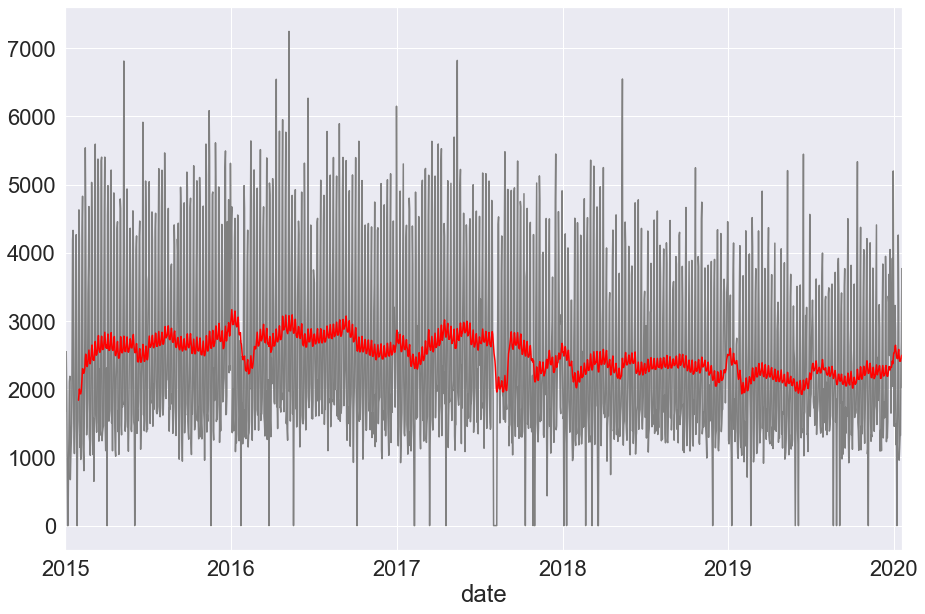

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
r = df.rolling(window = 30)
df['total'].plot(color = 'gray')
r.mean()['total'].plot(color = 'red');

In [9]:
total = df[['total']]

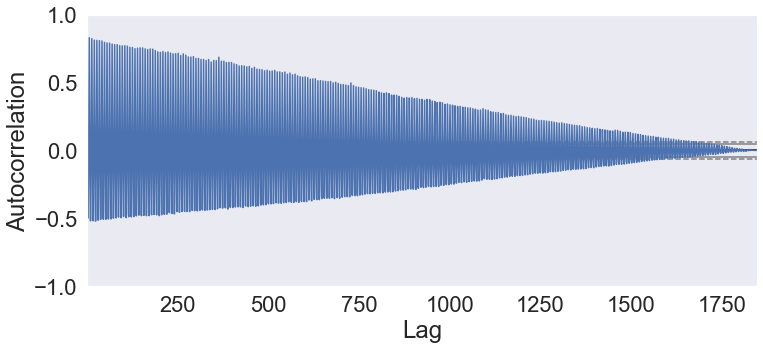

In [10]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(total);

In [11]:
temp_max = df[['temperatureMax']]

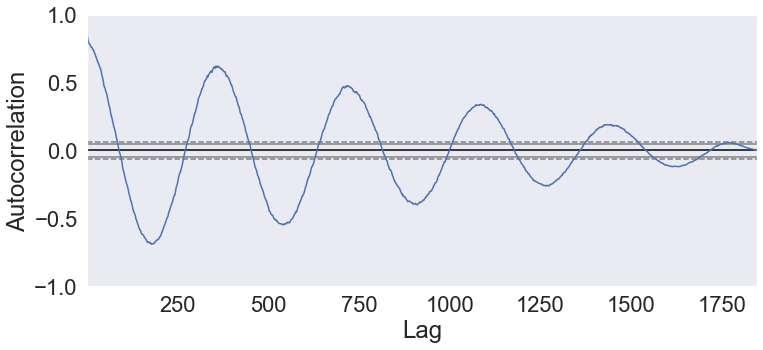

In [12]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(temp_max);

### Weekly EDA

In [13]:
total_weekly = df['total'].resample('W').mean()
weather_weekly = df['temperatureMax'].resample('W').mean()

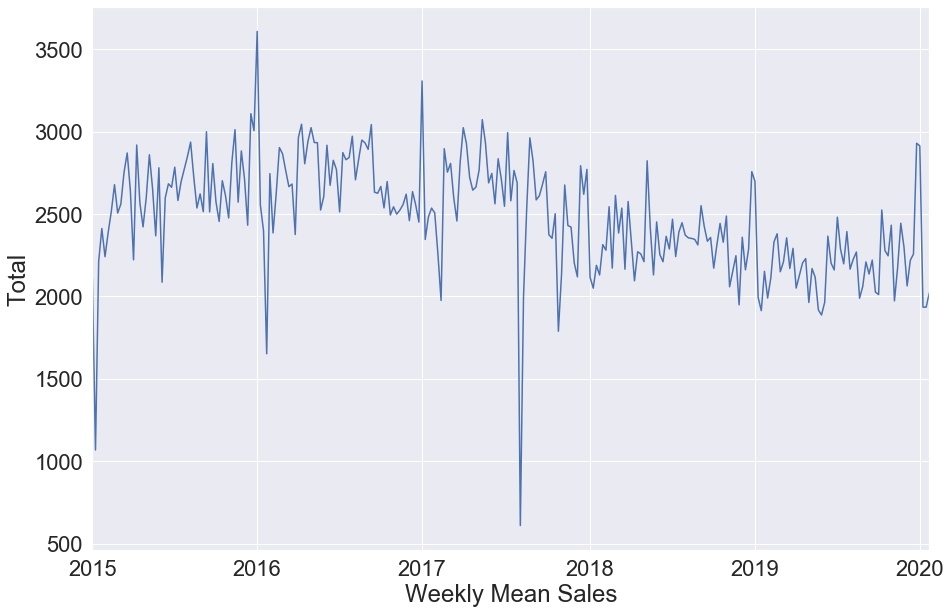

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
total_weekly.plot();
ax.set_xlabel('Weekly Mean Sales');
ax.set_ylabel('Total');

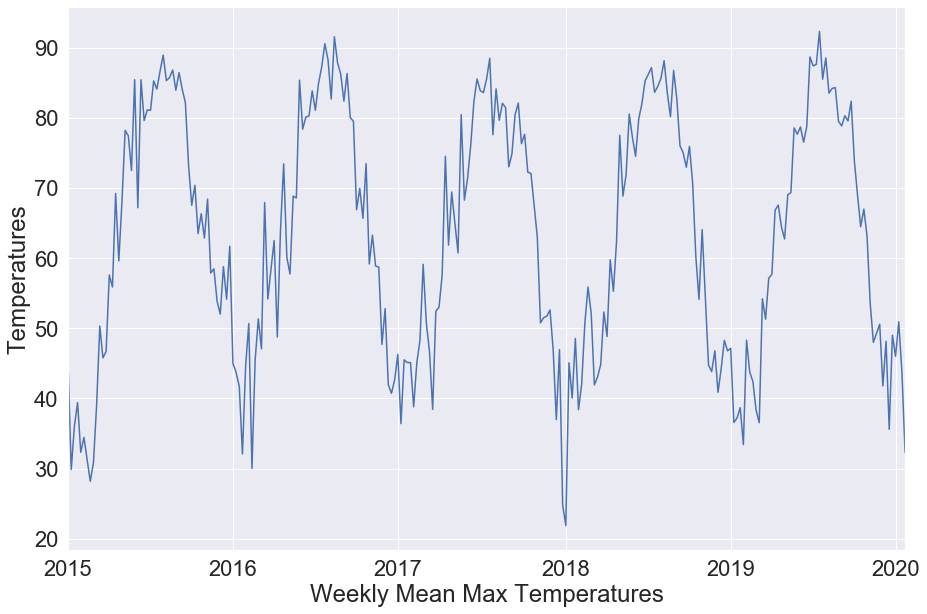

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
weather_weekly.plot();
ax.set_xlabel('Weekly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

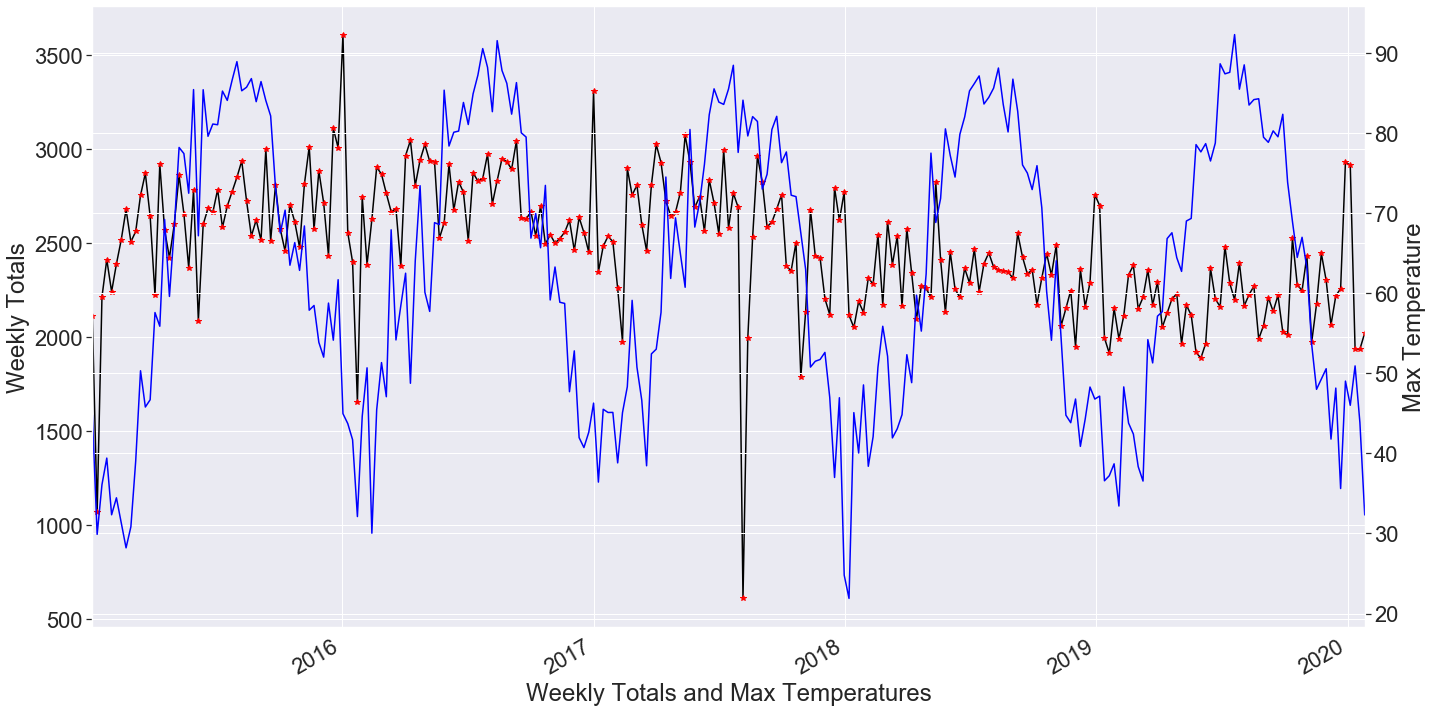

In [16]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Weekly Totals')
ax1.plot(total_weekly, color = 'black')
total_weekly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_weekly, color = 'blue')

ax1.set_xlabel('Weekly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

### Monthly EDA

In [17]:
total_monthly = df['total'].resample('MS').mean()
weather_monthly = df['temperatureMax'].resample('MS').mean()

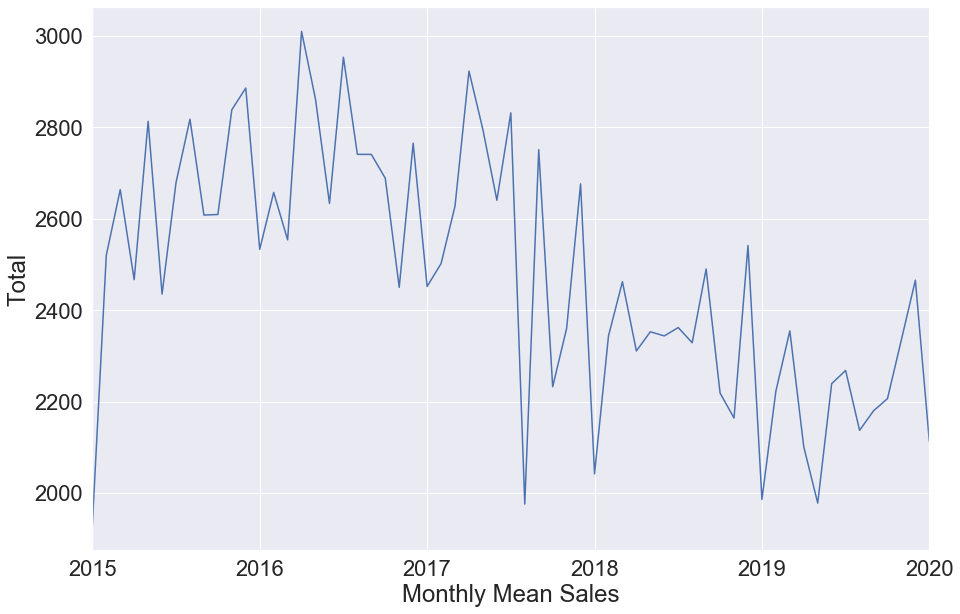

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
total_monthly.plot();
ax.set_xlabel('Monthly Mean Sales');
ax.set_ylabel('Total');

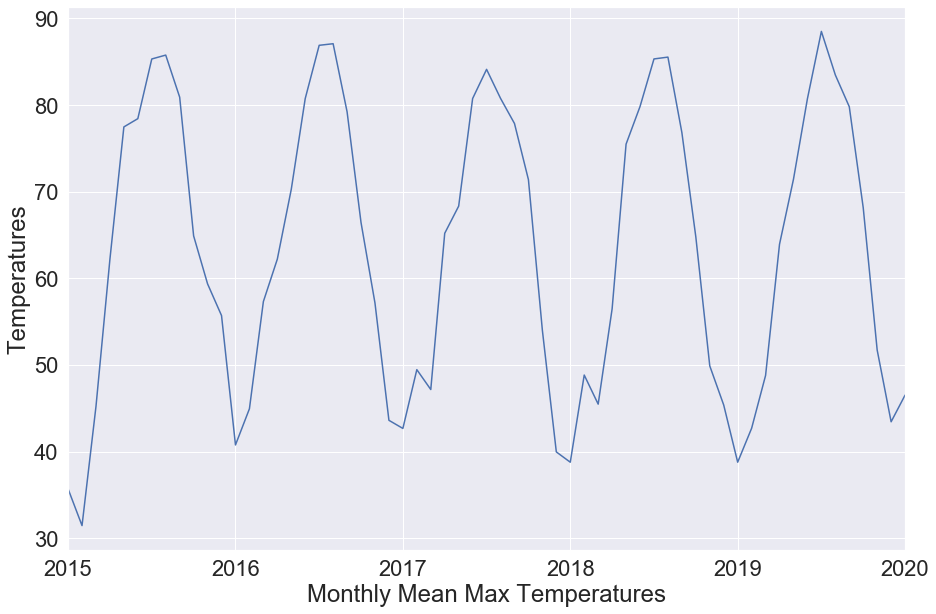

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
weather_monthly.plot();
ax.set_xlabel('Monthly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

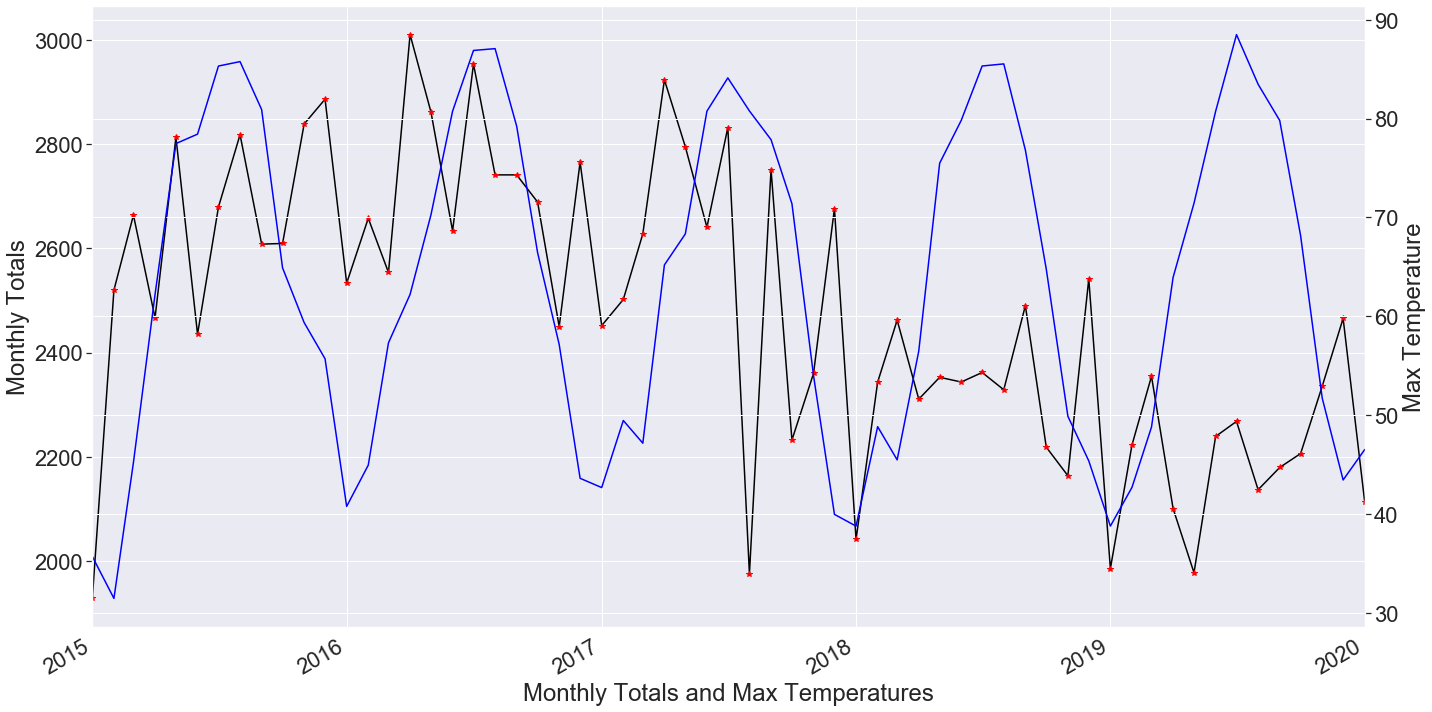

In [20]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Monthly Totals')
ax1.plot(total_monthly, color = 'black')
total_monthly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_monthly, color = 'blue')

ax1.set_xlabel('Monthly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

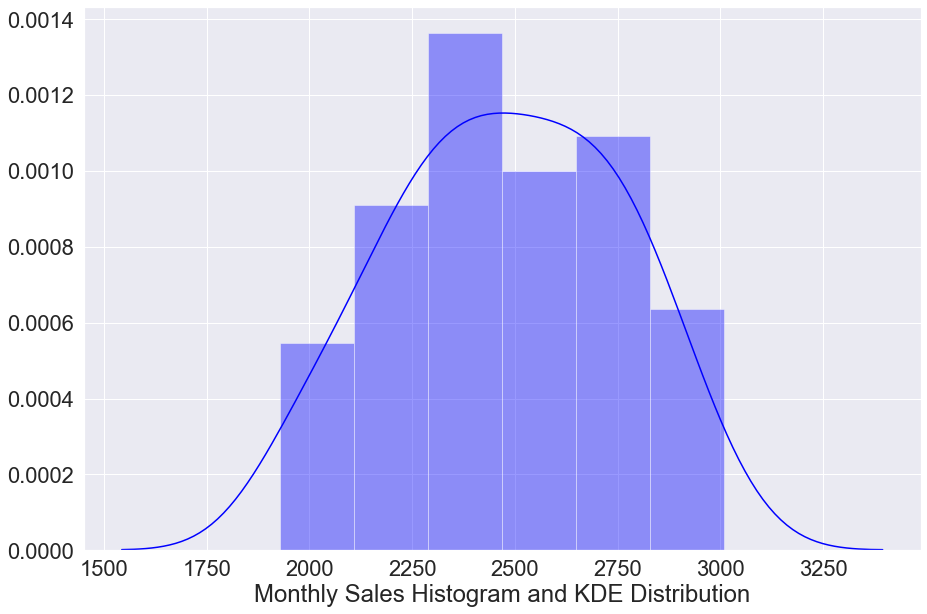

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(total_monthly, color='blue')
ax.set_xlabel('Monthly Sales Histogram and KDE Distribution');

### Yearly EDA

In [22]:
total_yearly = df['total'].resample('YS').mean()
weather_yearly = df['temperatureMax'].resample('YS').mean()

total_year_groups = total_monthly.groupby(pd.Grouper(freq ='A'))
weather_year_groups = weather_monthly.groupby(pd.Grouper(freq = 'A'))

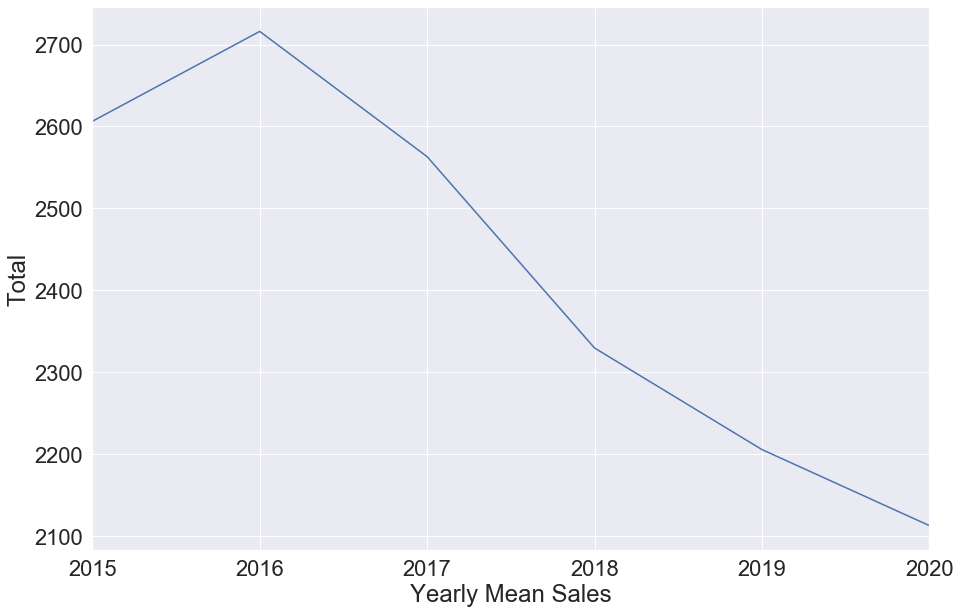

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
total_yearly.plot();
ax.set_xlabel('Yearly Mean Sales');
ax.set_ylabel('Total');

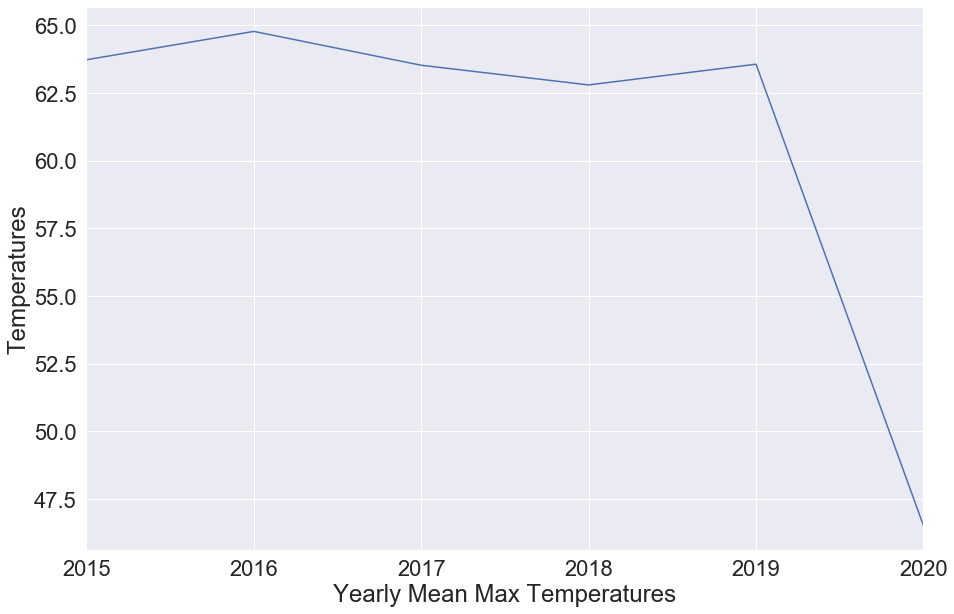

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
weather_yearly.plot();
ax.set_xlabel('Yearly Mean Max Temperatures');
ax.set_ylabel('Temperatures');

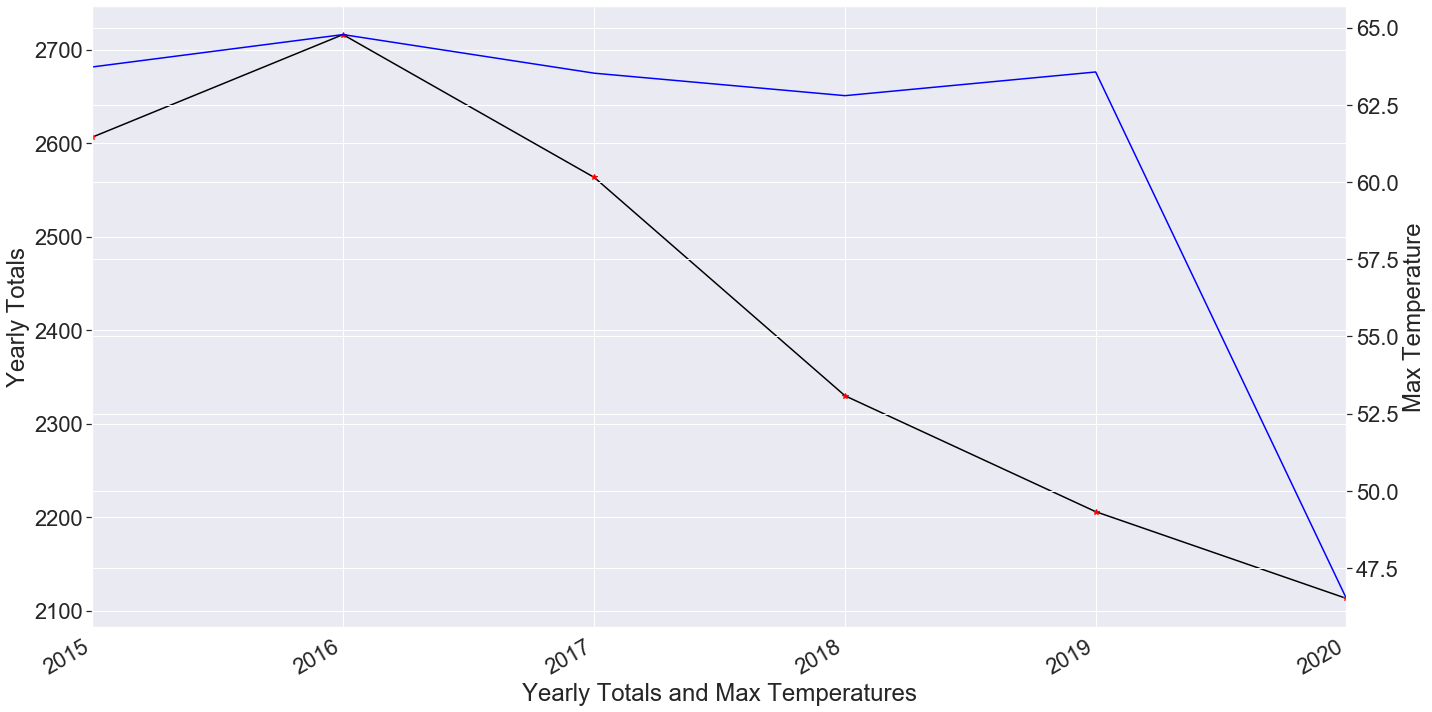

In [25]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_ylabel('Yearly Totals')
ax1.plot(total_yearly, color = 'black')
total_yearly.plot(style = '*', color = 'red')

ax2 = ax1.twinx()
ax2.set_ylabel('Max Temperature')
ax2.plot(weather_yearly, color = 'blue')

ax1.set_xlabel('Yearly Totals and Max Temperatures')
fig.tight_layout()
plt.show()

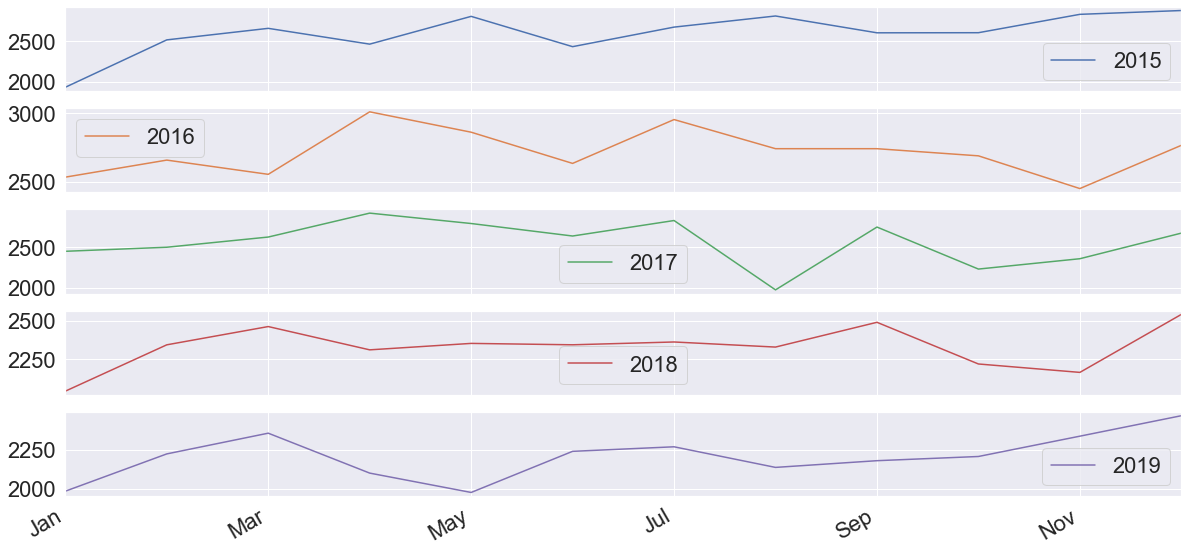

In [26]:
# Create a new DataFrame and store yearly values in columns 
total_annual = pd.DataFrame()
# weather_annual = pd.DataFrame()

for yr, group in total_year_groups:
#     print(f'year: {yr} || yr.year: {yr.year} || group: {group}')
    if yr.year < 2020:
        total_annual[yr.year] = group.values.ravel()
    else:
        pass
    
# for yr, group in weather_year_groups:
#     weather_annual[yr.year] = group.values.ravel()
    
total_annual = total_annual.rename({0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 
                                     4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 
                                     8:'Sep', 9:'Oct', 10:'Nov', 11:'Dec'})
    
# Plot the yearly groups as subplots
total_annual.plot(figsize = (20,10), subplots=True, legend=True);
# weather_annual.plot(figsize = (20,10), subplots=True, legend=True);

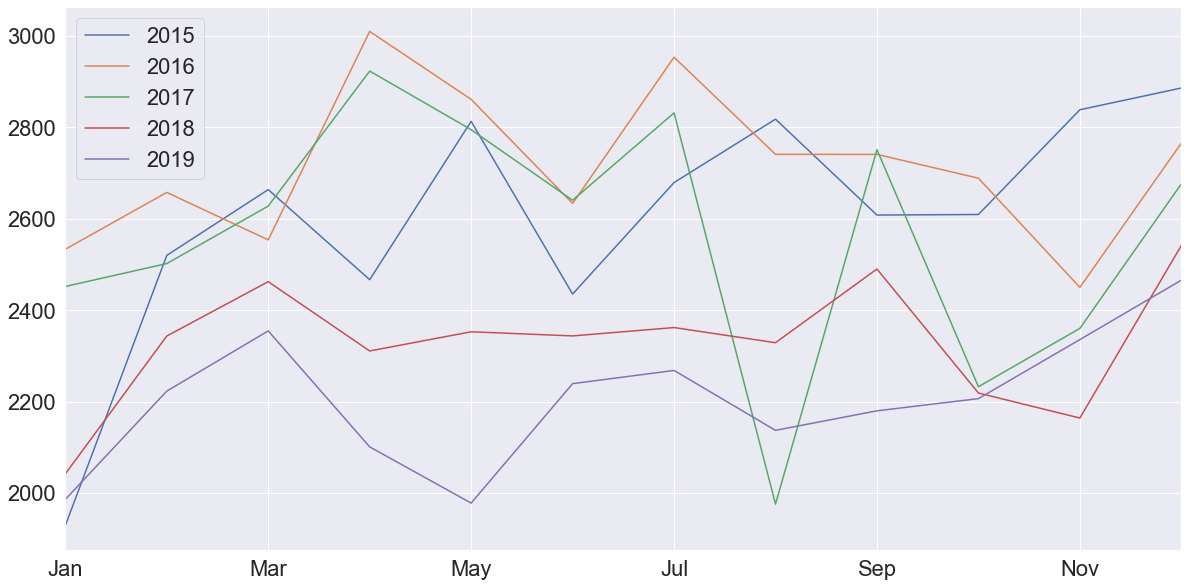

In [27]:
total_annual.plot(figsize = (20,10), subplots=False, legend=True);

In [28]:
# df_july_28 = pd.DataFrame([], columns = ['ds','holiday'])
# ldates = []
# lnames = []
# for date, name in sorted(holidays.PE(years=np.arange(2015, 2019 + 1)).items()):
#     if 'Independence Day' in name:
#         ldates.append(date)
#         lnames.append(name)
        
# ldates = np.array(ldates)
# lnames = np.array(lnames)

# df_july_28.loc[:,'ds'] = ldates
# df_july_28.loc[:,'holiday'] = lnames

# df_july_28.loc[:,'holiday'] = df_july_28.loc[:,'holiday'].apply \
# (lambda x : x.replace('Día de la Independencia [Independence Day]','Peruvian Independence Day'))

In [29]:
# Dataframe to house holidays
us_holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

#append dates and holiday names
ldates = []
lnames = []
for date, name in sorted(holidays.US(years=np.arange(2015, 2020 + 1)).items()):
    if 'Observed' in name:
        pass
    elif 'Columbus' in name:
        pass
    elif 'Martin Luther' in name:
        pass
    elif 'Washington' in name:
        pass
    else:
        ldates.append(date)
        lnames.append(name)

ldates = np.array(ldates)
lnames = np.array(lnames)

us_holidays_df.loc[:,'ds'] = ldates
us_holidays_df.loc[:,'holiday'] = lnames

In [30]:
# Creating DataFrame to house custom_holidays
custom_holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
custom_holidays = holidays.HolidayBase()
custom_holidays.append({'2015-02-14': "Valentine's Day", '2015-07-28': 'Peru Independence Day',
                        '2016-02-14': "Valentine's Day", '2016-07-28': 'Peru Independence Day',
                        '2017-02-14': "Valentine's Day", '2017-07-28': 'Peru Independence Day',
                        '2018-02-14': "Valentine's Day", '2018-07-28': 'Peru Independence Day',
                        '2019-02-14': "Valentine's Day", '2019-07-28': 'Peru Independence Day',
                        '2020-02-14': "Valentine's Day", '2020-07-28': 'Peru Independence Day'})
ldates = []
lnames = []
for date, name in sorted(custom_holidays.items()):
    ldates.append(date)
    lnames.append(name)

ldates = np.array(ldates)
lnames = np.array(lnames)

custom_holidays_df.loc[:,'ds'] = ldates
custom_holidays_df.loc[:,'holiday'] = lnames

In [31]:
# Merging both us holiday and custom holiday dataframes together
us_holidays_df = pd.concat([us_holidays_df,custom_holidays_df], ignore_index=True)
us_holidays_df.loc[:,'holiday'] = us_holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' Day',''))
us_holidays_df = us_holidays_df.sort_values(by=['ds'])
us_holidays_df['ds'] = pd.to_datetime(us_holidays_df['ds'])
us_holidays_df = us_holidays_df.set_index('ds')

In [32]:
# Check what holidays are contained
us_holidays_df = us_holidays_df.reset_index()
us_holidays_df['holiday'].unique()

array(["New Year's", "Valentine's", 'Memorial', 'Independence',
       'Peru Independence', 'Labor', 'Veterans', 'Thanksgiving',
       'Christmas'], dtype=object)

In [33]:
df_sales_avg_holidays = df[['total']]
df_sales_avg_holidays = df_sales_avg_holidays.reset_index()
df_sales_avg_holidays = df_sales_avg_holidays.rename(columns={'date':'ds'})

In [34]:
df_sales_avg_holidays = pd.merge(df_sales_avg_holidays, us_holidays_df, on='ds')

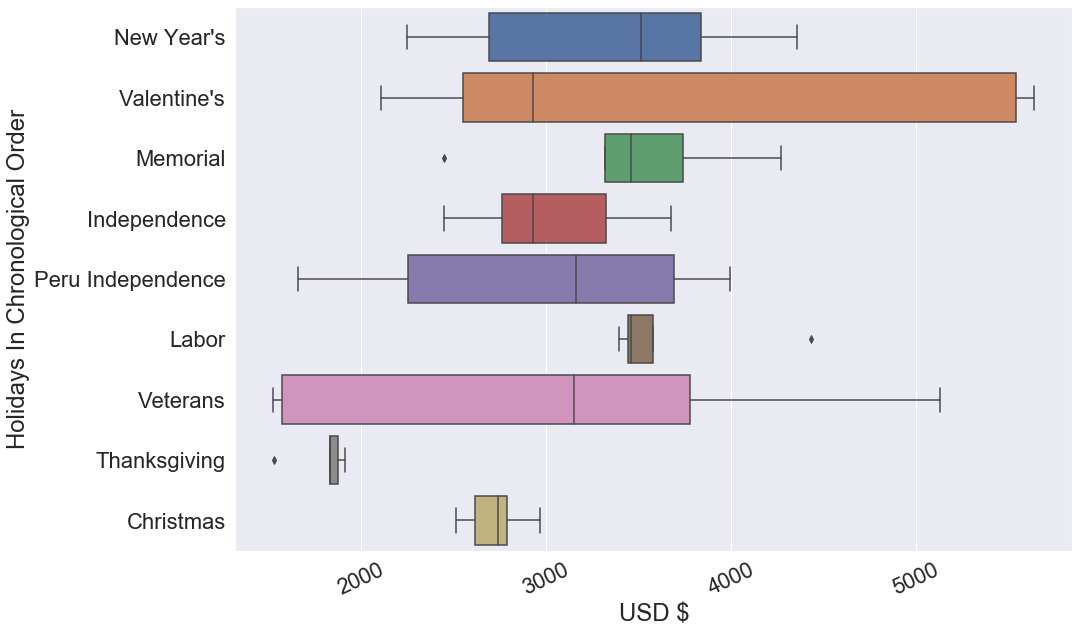

In [68]:
y = df_sales_avg_holidays.pivot(columns='holiday', values='total')
cols = ["New Year's", "Valentine's", "Memorial", "Independence", "Peru Independence", "Labor", "Veterans", "Thanksgiving", "Christmas"]
y = y[cols]
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation=25)
ax = sns.boxplot(data=y, orient="h");
ax.set(xlabel = 'USD $', ylabel = 'Holidays In Chronological Order');
fig.savefig("../figures/slides/Holiday_Trends.png")

In [36]:
df_sales_avg_DOW = df[['total']]
df_sales_avg_DOW['week_days'] = df_sales_avg_DOW.index.weekday
df_sales_avg_DOW['week_days'] = df_sales_avg_DOW['week_days'].replace({0:'Mon', 1:'Tues', 
                                                                       2:'Wed', 3:'Thu', 
                                                                       4:'Fri', 5:'Sat', 6:'Sun'})

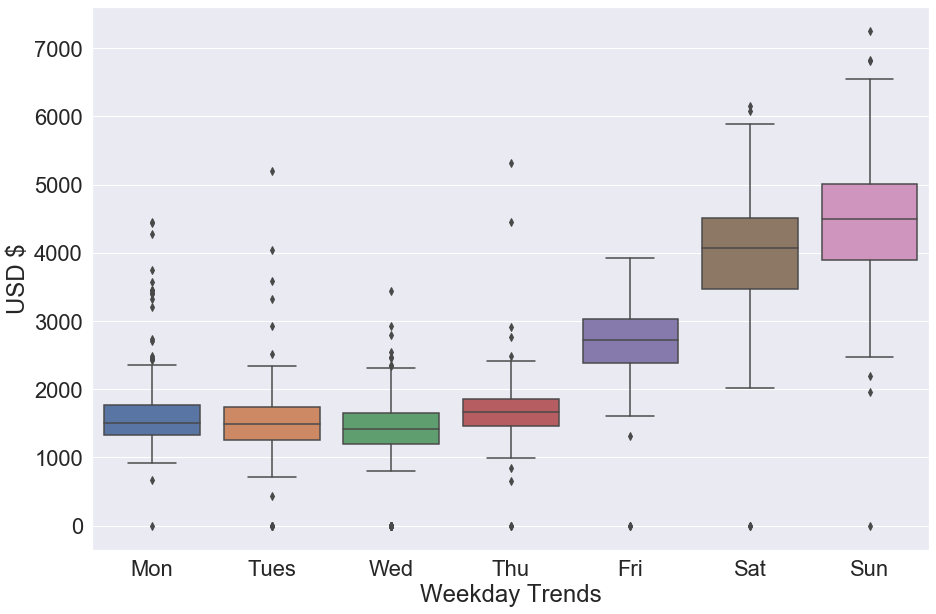

In [67]:
x = df_sales_avg_DOW.pivot(columns='week_days', values='total')
x = x[['Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(data=x);
ax.set(xlabel = 'Weekday Trends', ylabel = 'USD $');
fig.savefig("../figures/slides/Weekday_Trends.png")

In [54]:
df_sales_avg_MOY = df[['total']]
df_sales_avg_MOY['months'] = df_sales_avg_MOY.index.month
df_sales_avg_MOY['months'] = df_sales_avg_MOY['months'].replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 
                                                                 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 
                                                                 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

# total_annual = total_annual.rename({ 1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 
#                                      5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 
#                                      9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})


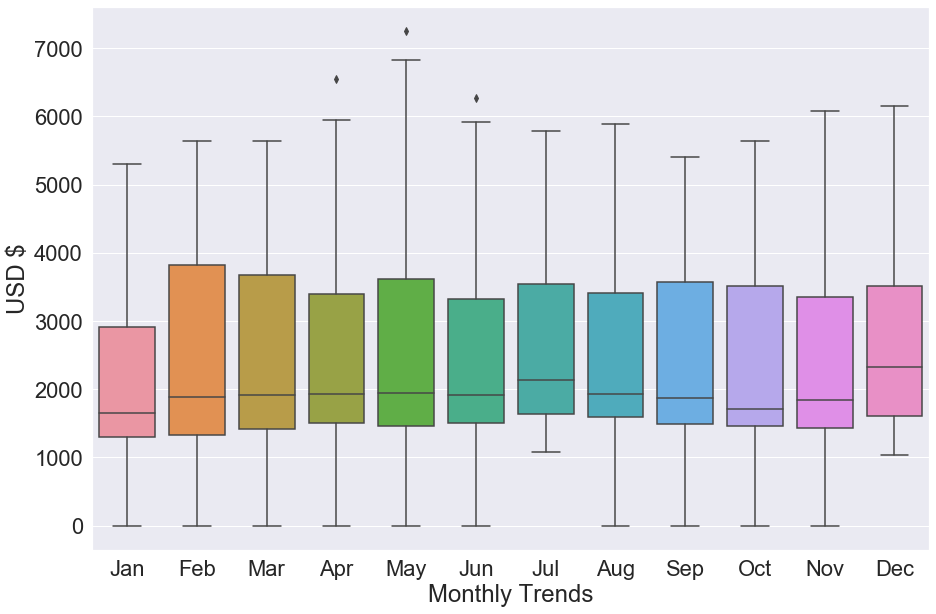

In [66]:
z = df_sales_avg_MOY.pivot(columns='months', values='total')
z = z[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(data=z);
ax.set(xlabel = 'Monthly Trends', ylabel = 'USD $');
fig.savefig("../figures/slides/Monthly_Trends.png")

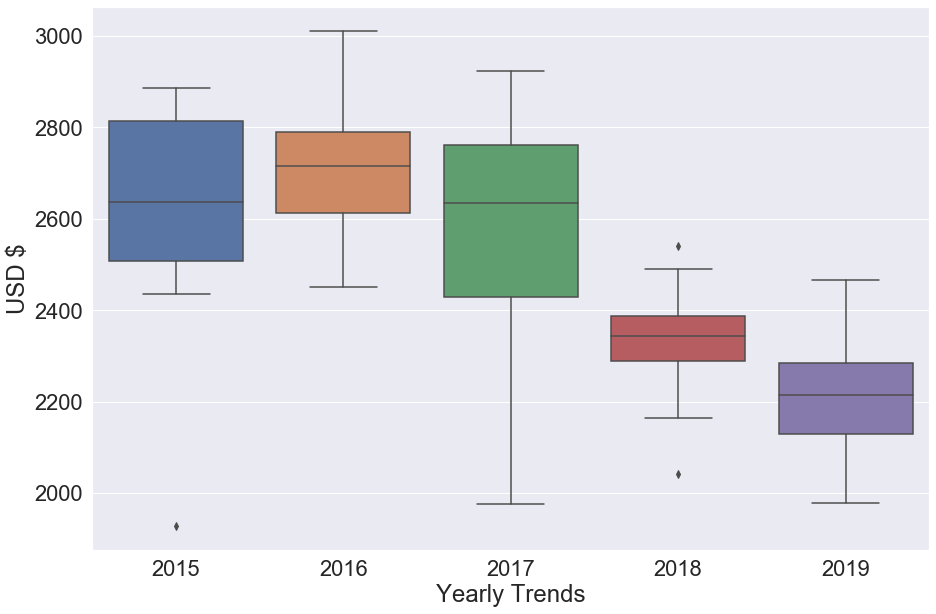

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(data=total_annual);
ax.set(xlabel = 'Yearly Trends', ylabel = 'USD $');
fig.savefig("../figures/slides/Yearly_Trends.png")

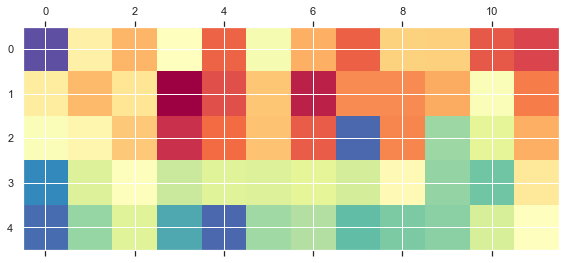

In [439]:
year_matrix = total_annual.T
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r);

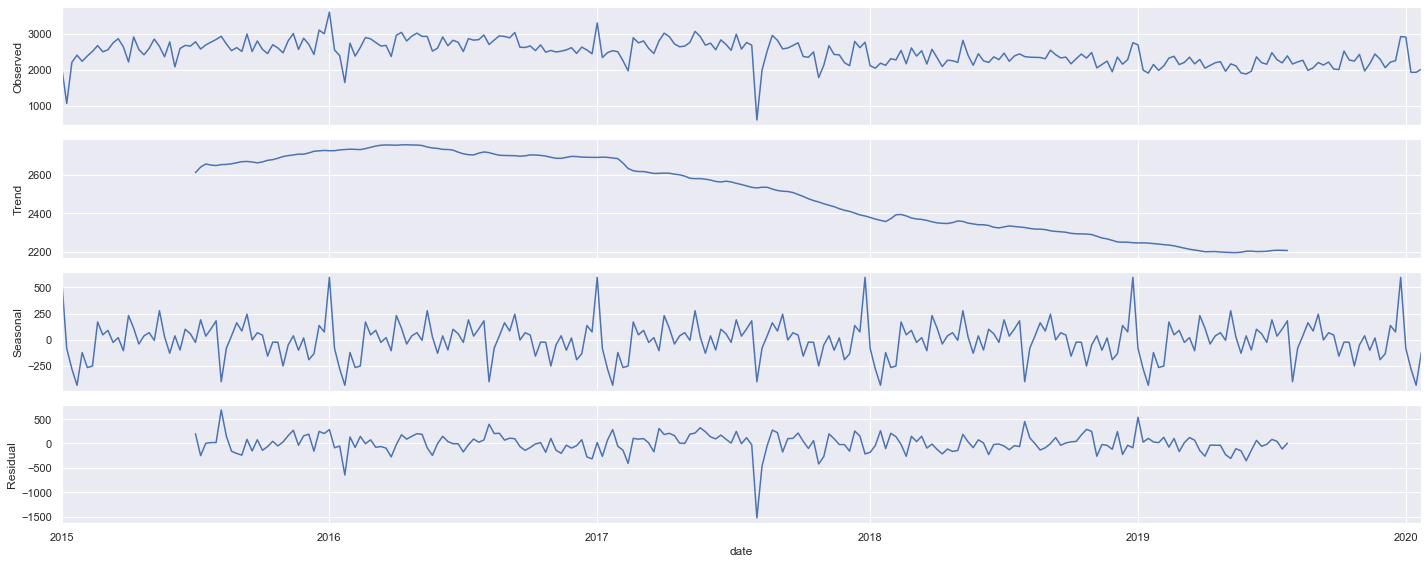

In [440]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_weekly, model='additive')
fig = decomposition.plot()
plt.show()

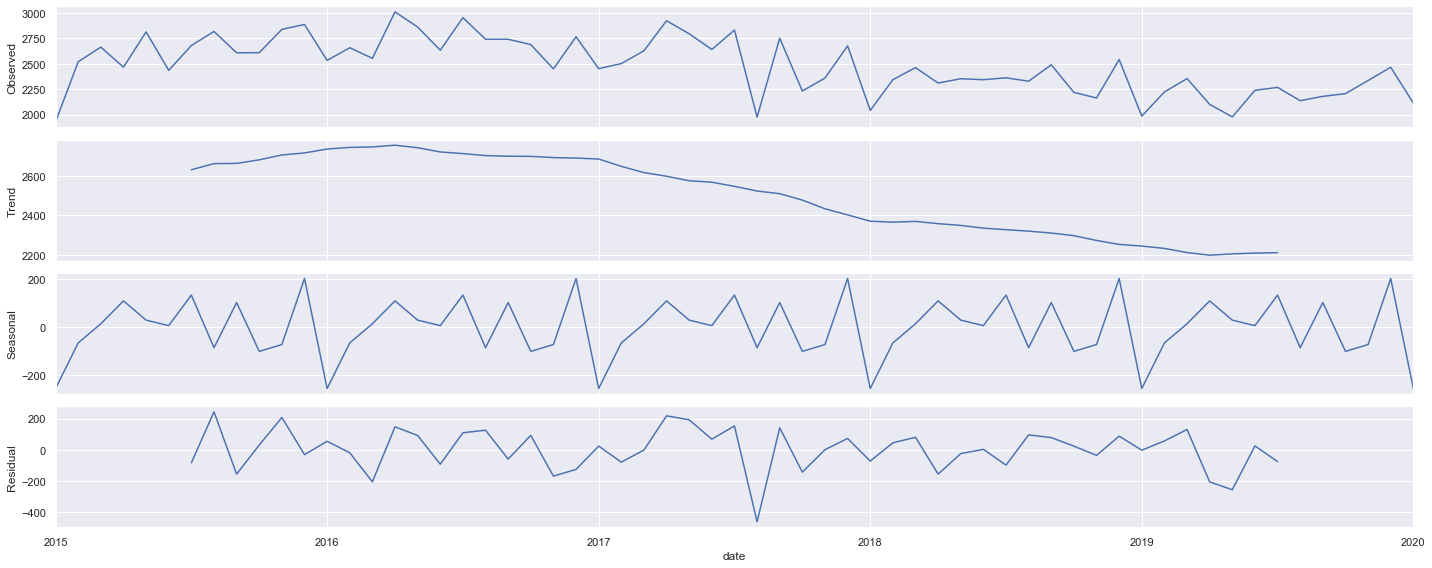

In [35]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_monthly, model='additive')
fig = decomposition.plot()
plt.show()

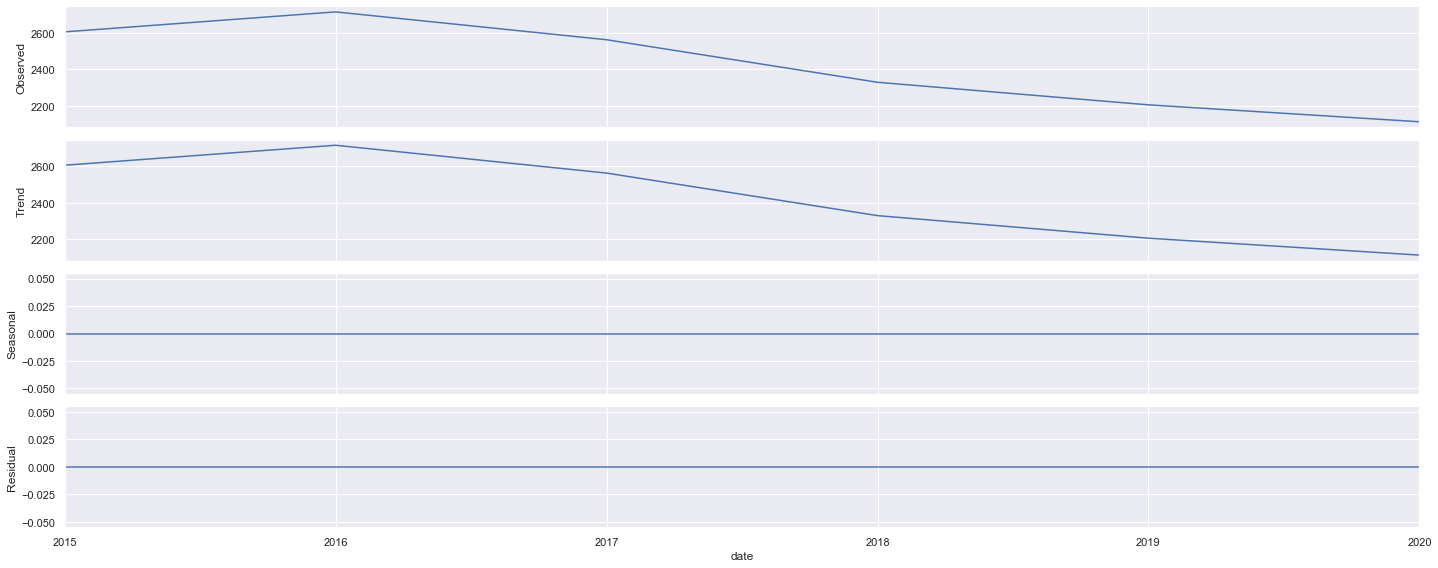

In [36]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(total_yearly, model='additive')
fig = decomposition.plot()
plt.show()

In [37]:
total_monthly_reset_index = pd.DataFrame(total_monthly).reset_index()

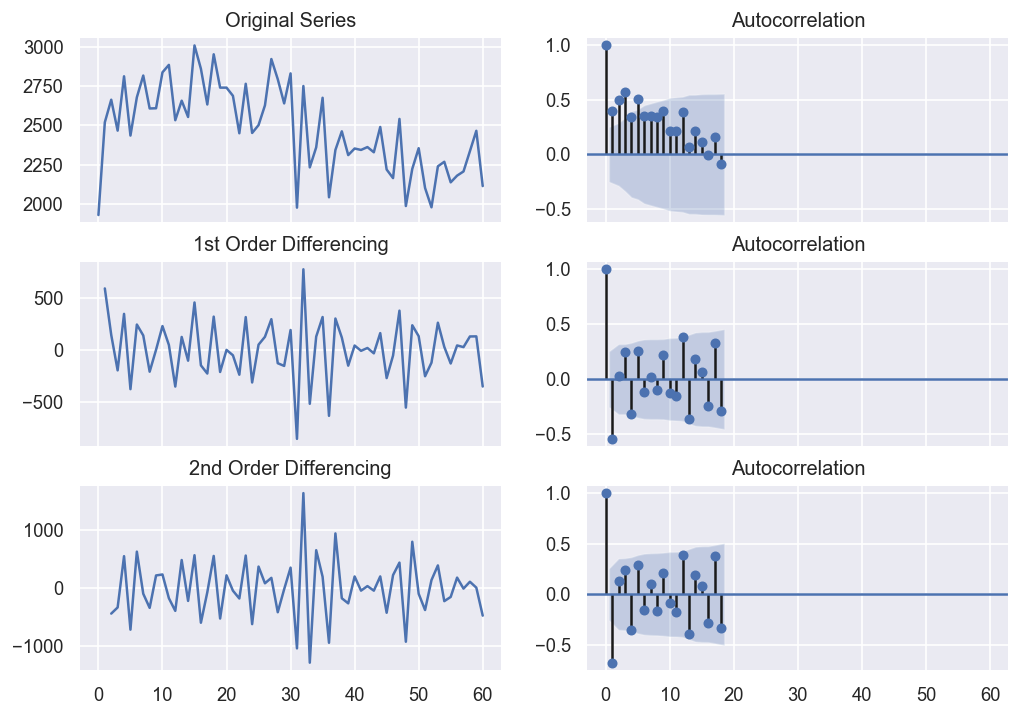

In [38]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(total_monthly_reset_index.total); axes[0, 0].set_title('Original Series')
plot_acf(total_monthly_reset_index.total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(total_monthly_reset_index.total.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(total_monthly_reset_index.total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(total_monthly_reset_index.total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(total_monthly_reset_index.total.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
